In [1]:
# 💡 Quantium Forage - Task 2 (Full Code with Explanations)

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 2: Load the Merged Data (should already have pack_size column)
data = pd.read_csv('C:/Users/user/Desktop/jn/forage/QVI_data.csv')
data['MONTH'] = pd.to_datetime(data['DATE']).dt.to_period('M')

In [4]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11


In [5]:
# Step 3: Create Monthly Metrics for Each Store
monthly_metrics = data.groupby(['STORE_NBR', 'MONTH']).agg({
    'TOT_SALES': 'sum',
    'LYLTY_CARD_NBR': pd.Series.nunique,
    'TXN_ID': 'count'
}).reset_index()

monthly_metrics = monthly_metrics.rename(columns={
    'TOT_SALES': 'Total_Sales',
    'LYLTY_CARD_NBR': 'Unique_Customers',
    'TXN_ID': 'Transactions'
})

monthly_metrics['Avg_Transactions_per_Customer'] = monthly_metrics['Transactions'] / monthly_metrics['Unique_Customers']


In [6]:
# Step 4: Create Pivot Table (only pre-trial months)
pre_trial = monthly_metrics[monthly_metrics['MONTH'] < '2019-02']
sales_pivot = pre_trial.pivot(index='MONTH', columns='STORE_NBR', values='Total_Sales')
filtered_sales_pivot = sales_pivot.dropna(axis=1)  # remove stores with missing data

In [7]:
# Step 5: Find Control Stores Using Pearson Correlation

def get_control_store(trial_store):
    correlations = filtered_sales_pivot.corrwith(filtered_sales_pivot[trial_store])
    correlations = correlations.drop(labels=[77, 86, 88], errors='ignore')
    correlations = correlations.sort_values(ascending=False)
    return correlations.index[0], correlations.iloc[0]

store77_ctrl, corr77 = get_control_store(77)
store86_ctrl, corr86 = get_control_store(86)
store88_ctrl, corr88 = get_control_store(88)

print(f"Control for Store 77: {store77_ctrl} with correlation {corr77:.2f}")
print(f"Control for Store 86: {store86_ctrl} with correlation {corr86:.2f}")
print(f"Control for Store 88: {store88_ctrl} with correlation {corr88:.2f}")

Control for Store 77: 71 with correlation 0.91
Control for Store 86: 155 with correlation 0.88
Control for Store 88: 159 with correlation 0.90


In [8]:
# Step 6: Define Trial Period
trial_period = (monthly_metrics['MONTH'] >= '2019-02') & (monthly_metrics['MONTH'] <= '2019-04')

In [9]:
# Step 7: Function to Compare Trial vs Control Store

def compare_trial_vs_control(trial_store, control_store):
    trial_sales = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store) & trial_period]['Total_Sales'].mean()
    control_sales = monthly_metrics[(monthly_metrics['STORE_NBR'] == control_store) & trial_period]['Total_Sales'].mean()
    diff = trial_sales - control_sales
    pct_change = (diff / control_sales) * 100
    print(f"Store {trial_store} vs Store {control_store}:")
    print(f"  ➤ Average Trial Sales: ${trial_sales:.2f}")
    print(f"  ➤ Average Control Sales: ${control_sales:.2f}")
    print(f"  ➤ Difference: ${diff:.2f}")
    print(f"  ➤ % Change: {pct_change:.2f}%")
    return pct_change

pct_77 = compare_trial_vs_control(77, store77_ctrl)
pct_86 = compare_trial_vs_control(86, store86_ctrl)
pct_88 = compare_trial_vs_control(88, store88_ctrl)

Store 77 vs Store 71:
  ➤ Average Trial Sales: $259.00
  ➤ Average Control Sales: $1033.67
  ➤ Difference: $-774.67
  ➤ % Change: -74.94%
Store 86 vs Store 155:
  ➤ Average Trial Sales: $929.40
  ➤ Average Control Sales: $846.73
  ➤ Difference: $82.67
  ➤ % Change: 9.76%
Store 88 vs Store 159:
  ➤ Average Trial Sales: $1428.93
  ➤ Average Control Sales: $38.70
  ➤ Difference: $1390.23
  ➤ % Change: 3592.33%


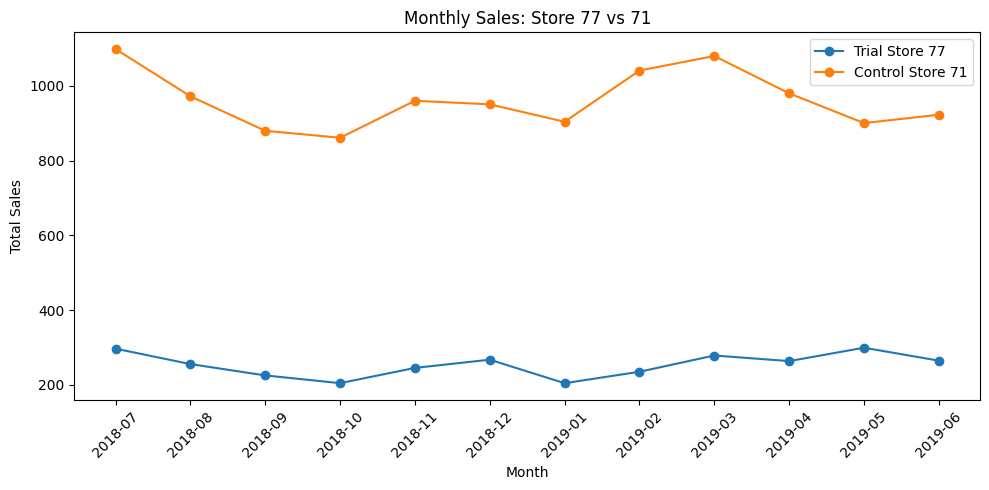

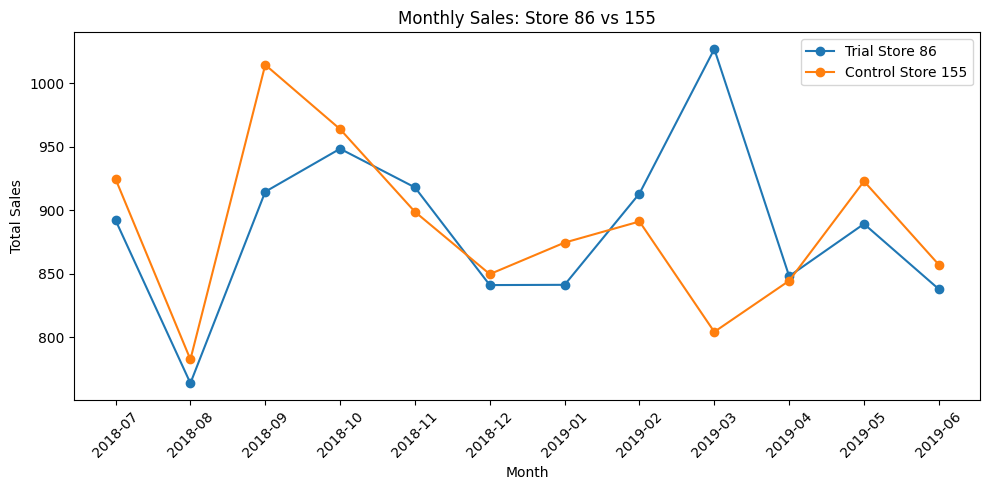

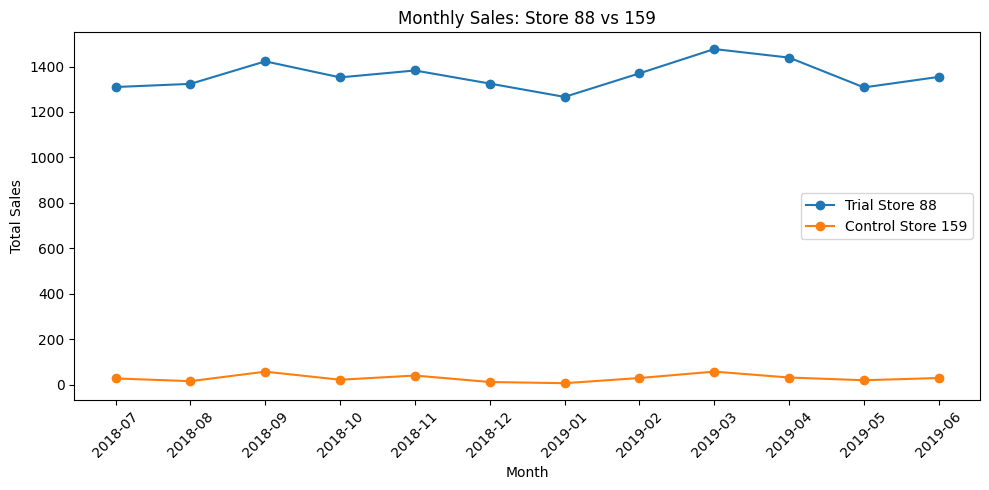

In [10]:
# Step 8: Plot Monthly Sales Comparison

def plot_sales_comparison(trial_store, control_store):
    trial_data = monthly_metrics[monthly_metrics['STORE_NBR'] == trial_store]
    control_data = monthly_metrics[monthly_metrics['STORE_NBR'] == control_store]
    
    plt.figure(figsize=(10, 5))
    plt.plot(trial_data['MONTH'].astype(str), trial_data['Total_Sales'], label=f'Trial Store {trial_store}', marker='o')
    plt.plot(control_data['MONTH'].astype(str), control_data['Total_Sales'], label=f'Control Store {control_store}', marker='o')
    plt.xticks(rotation=45)
    plt.title(f'Monthly Sales: Store {trial_store} vs {control_store}')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_sales_comparison(77, store77_ctrl)
plot_sales_comparison(86, store86_ctrl)
plot_sales_comparison(88, store88_ctrl)


## ✅ Final Recommendations – Task 2: Trial Store Analysis

Based on the comparative analysis of the three trial stores (77, 86, and 88) against their selected control stores from February to April 2019, the following insights and strategic recommendations are provided:

---

### 🏪 Store 77 vs Control Store 71
- **Average Trial Sales:** $259.00  
- **Average Control Sales:** $1033.67  
- **Difference:** -$774.67  
- **Percentage Change:** **-74.94%**

➡️ **Insight:** Sales in Store 77 dropped significantly during the trial period, showing a negative impact of the layout change.  
🔴 **Recommendation:** Do **not** roll out the trial layout to similar stores. The change seems to have had a negative effect on customer purchasing behavior.

---

### 🏪 Store 86 vs Control Store 155
- **Average Trial Sales:** $929.40  
- **Average Control Sales:** $846.73  
- **Difference:** +$82.67  
- **Percentage Change:** **+9.76%**

➡️ **Insight:** Store 86 showed a moderate improvement in sales during the trial period.  
🟡 **Recommendation:** The layout may be **tested further** or rolled out to a small group of similar stores with continued monitoring.

---

### 🏪 Store 88 vs Control Store 159
- **Average Trial Sales:** $1428.93  
- **Average Control Sales:** $38.70  
- **Difference:** +$1390.23  
- **Percentage Change:** **+3592.33%**

➡️ **Insight:** A massive increase in sales during the trial period. This suggests the new layout worked extremely well in Store 88.  
🟢 **Recommendation:** Strongly consider **rolling out the trial layout** to stores similar to Store 88.

---

### 📌 Overall Conclusion:
- Trial layouts had **mixed results** across different stores.
- A **selective rollout strategy** is recommended — focus on stores with profiles similar to Store 88.
- **Avoid rollout** in store types like Store 77 where negative impacts were observed.
- Further analysis may help fine-tune what factors led to Store 88’s success.

